In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import unicodedata
import string
import nltk
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import des fichiers .csv des 28 promotions

In [2]:
batches = []
for i in range(1,29):
    batches.append(pd.read_excel(r'D:\_IMSD\Python\Project\promotions\batch_{}.xlsx'.format(i), header=0))

df = pd.concat(batches)
df.reset_index(drop=True, inplace=True)
df = df.drop('Unnamed: 0', axis=1)

In [3]:
df.head()

,Name,Batch,Category,Description,Status
0,Airtime,S05,NaN,Airtime is a live video platform that allows p...,\n .\n Live\n ...
1,Clickfacts,S05,Other SaaS,ClickFacts is a malware software solutions com...,\n .\n Exited\n ...
2,Infogami,S05,Other SaaS,NaN,\n .\n Dead\n ...
3,Kiko,S05,Other SaaS,We're the best online calendar solution to eve...,\n .\n Exited\n ...
4,Loopt,S05,Entertainment,Loopt is a mobile application and website that...,\n .\n Exited\n ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 5 columns):
Name           1752 non-null object
Batch          1752 non-null object
Category       1747 non-null object
Description    1730 non-null object
Status         1752 non-null object
dtypes: object(5)
memory usage: 68.5+ KB


# Nombre de NaN dans 'Category' & "Description" + suppression

In [5]:
df.isna().sum()

Name            0
Batch           0
Category        5
Description    22
Status          0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1726 entries, 1 to 1751
Data columns (total 5 columns):
Name           1726 non-null object
Batch          1726 non-null object
Category       1726 non-null object
Description    1726 non-null object
Status         1726 non-null object
dtypes: object(5)
memory usage: 80.9+ KB


# Nettoyage des "Status"

In [7]:
for i in range(df.shape[0]):
    if 'Exited' in df.Status.iloc[i]:
        df.iloc[i].Status = 'exited'
    elif 'Live' in df.Status.iloc[i]:
        df.iloc[i].Status = 'live'
    elif 'Dead' in df.Status.iloc[i]:
        df.iloc[i].Status = 'dead'
    else:
        print('Non expected values.')
df.head()

,Name,Batch,Category,Description,Status
1,Clickfacts,S05,Other SaaS,ClickFacts is a malware software solutions com...,exited
3,Kiko,S05,Other SaaS,We're the best online calendar solution to eve...,exited
4,Loopt,S05,Entertainment,Loopt is a mobile application and website that...,exited
7,Posthaven,S05,Entertainment,Blogging forever,dead
8,Reddit,S05,Entertainment,The frontpage of the internet.,exited


# Aperçu des catégories

In [8]:
cat = df.groupby('Category')['Name'].count()
print(cat)

Category
Aerospace         26
Agriculture       18
Consumer         268
Dev Tools        131
Education         47
Entertainment    207
Fintech          131
Government        17
Healthcare       193
Industrial        25
Nonprofit         25
Other SaaS       553
Real Estate       51
Resources         23
Transport         11
Name: Name, dtype: int64


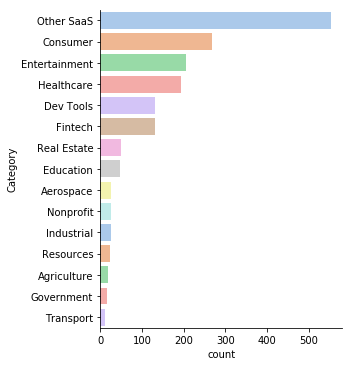

In [9]:
sns.catplot(
    y="Category", kind="count", 
    palette="pastel", data=df,
    order=df['Category'].value_counts().index
)

# Visualisation des mots les plus utilisés avant nettoyage

In [10]:
all_words = df['Description'].str.split(expand=True).unstack().value_counts()
print(all_words[:10])

and     961
for     803
to      683
the     529
a       456
is      387
of      289
in      281
We      253
that    230
dtype: int64


# Traitement de la donnée

#### Création d'un nouveau DataFrame contenant uniquement les informations souhaitées

In [11]:
df.columns

Index(['Name', 'Batch', 'Category', 'Description', 'Status'], dtype='object')

In [12]:
data = df[['Category', 'Description']]
data.head()

,Category,Description
1,Other SaaS,ClickFacts is a malware software solutions com...
3,Other SaaS,We're the best online calendar solution to eve...
4,Entertainment,Loopt is a mobile application and website that...
7,Entertainment,Blogging forever
8,Entertainment,The frontpage of the internet.


In [13]:
# DATASET D'ENTRAINEMENT
copy = data.copy()

### Text cleaning

In [14]:
def nettoyage(desc):
    # suppression des caractères spéciaux
    desc = re.sub(r"[^ \w+0-9]", ' ', desc)
    # suppression des chiffres
    desc = re.sub('[0-9]', '', desc)
    # suppression des espaces
    desc = ' '.join(desc.split())
    # convertir le texte en minuscule
    desc = desc.lower()
    # suppression de la ponctuation
    desc = desc.translate(string.punctuation)
    # suppression des liens
    desc = desc.replace(r"https?://\S*", "")
    return desc

In [15]:
copy['cleaned_description'] = copy['Description'].apply(lambda x: nettoyage(x))

#### Stopwords et Lemmatization

In [16]:
# suppression des stopwords
stop_words = stopwords.words('english')

def stopwords(desc):
    desc_sans_stopwords = [w for w in desc.split() if not w in stop_words]
    return ' '.join(desc_sans_stopwords)

copy['cleaned_without_stopwords'] = copy['cleaned_description'].apply(lambda x: stopwords(x))

In [17]:
copy.head()

,Category,Description,cleaned_description,cleaned_without_stopwords
1,Other SaaS,ClickFacts is a malware software solutions com...,clickfacts is a malware software solutions com...,clickfacts malware software solutions company ...
3,Other SaaS,We're the best online calendar solution to eve...,we re the best online calendar solution to eve...,best online calendar solution ever exist period
4,Entertainment,Loopt is a mobile application and website that...,loopt is a mobile application and website that...,loopt mobile application website connects peop...
7,Entertainment,Blogging forever,blogging forever,blogging forever
8,Entertainment,The frontpage of the internet.,the frontpage of the internet,frontpage internet


In [18]:
def tokenize(text):
    stem = nltk.stem.SnowballStemmer('english')
    text = text.lower()
    
    for token in nltk.word_tokenize(text):
        if token in string.punctuation: continue
        yield stem.stem(token)

In [19]:
copy['cleaned_lemmatized'] = copy['cleaned_description'].apply(lambda x: tokenize(x))

In [20]:
copy.head()

,Category,Description,cleaned_description,cleaned_without_stopwords,cleaned_lemmatized
1,Other SaaS,ClickFacts is a malware software solutions com...,clickfacts is a malware software solutions com...,clickfacts malware software solutions company ...,<generator object tokenize at 0x0000014A16E11F48>
3,Other SaaS,We're the best online calendar solution to eve...,we re the best online calendar solution to eve...,best online calendar solution ever exist period,<generator object tokenize at 0x0000014A16E11B10>
4,Entertainment,Loopt is a mobile application and website that...,loopt is a mobile application and website that...,loopt mobile application website connects peop...,<generator object tokenize at 0x0000014A16E11930>
7,Entertainment,Blogging forever,blogging forever,blogging forever,<generator object tokenize at 0x0000014A16E11C78>
8,Entertainment,The frontpage of the internet.,the frontpage of the internet,frontpage internet,<generator object tokenize at 0x0000014A16E119A8>


#### Visualisation des mots les plus utilisés pour les 3 premières catégories

In [21]:
other_saas = copy[copy['Category'] == 'Other SaaS']['cleaned_without_stopwords'].values
consumer = copy[copy['Category'] == 'Consumer']['cleaned_without_stopwords'].values
entertainment = copy[copy['Category'] == 'Entertainment']['cleaned_without_stopwords'].values

In [22]:
# transformer le np.array en string
other_saas = np.array2string(other_saas) 
consumer = np.array2string(consumer)
entertainment = np.array2string(entertainment)

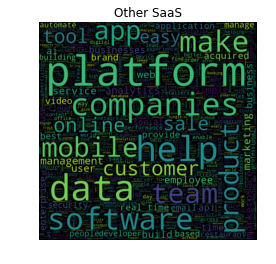

In [23]:
other_saas = WordCloud(
    width=1000, height=1000, margin=0,
    stopwords=STOPWORDS, background_color='black',
    max_words=10000
).generate(other_saas)

plt.imshow(other_saas, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Other SaaS')
plt.show()

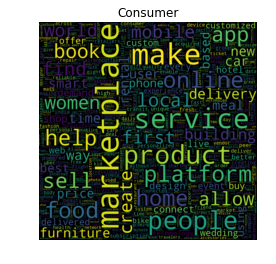

In [24]:
consumer = WordCloud(
    width=1000, height=1000, margin=0,
    stopwords=STOPWORDS, background_color='black',
    max_words=10000
).generate(consumer)

plt.imshow(consumer, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Consumer')
plt.show()

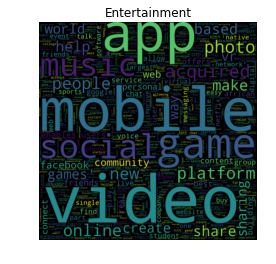

In [25]:
entertainment = WordCloud(
    width=1000, height=1000, margin=0,
    stopwords=STOPWORDS, background_color='black',
    max_words=10000
).generate(entertainment)

plt.imshow(entertainment, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Entertainment')
plt.show()

#### Text encoding - TF-IDF

In [26]:
corpus = copy.cleaned_without_stopwords

In [27]:
tfidf = TfidfVectorizer()
corpus = tfidf.fit_transform(corpus)

In [28]:
print(corpus)

  (0, 753)	0.4000322788470217
  (0, 2619)	0.36430473545828085
  (0, 4031)	0.19943248927620524
  (0, 4036)	0.32250618920767793
  (0, 841)	0.2407077422030348
  (0, 3449)	0.29284964868079916
  (0, 3895)	0.26400484067287266
  (0, 2982)	0.20103502093135622
  (0, 2687)	0.29617621896609564
  (0, 576)	0.3434054623329794
  (0, 3864)	0.32250618920767793
  (1, 2982)	0.23280344586905546
  (1, 414)	0.2815221625208861
  (1, 586)	0.42187374800762434
  (1, 4035)	0.33209664982255166
  (1, 1494)	0.43904524577758286
  (1, 1517)	0.43904524577758286
  (1, 3169)	0.43904524577758286
  (2, 2570)	0.5139899823470125
  (2, 2775)	0.271811127980008
  (2, 234)	0.37476285476895954
  (2, 4760)	0.37476285476895954
  (2, 895)	0.3887853309457492
  (2, 3160)	0.29906083536768424
  (2, 834)	0.37476285476895954
  :	:
  (1723, 2999)	0.427587052984734
  (1723, 2175)	0.33803885404549333
  (1723, 3763)	0.3267522966258797
  (1723, 2012)	0.3267522966258797
  (1723, 1358)	0.3705700931196048
  (1723, 1564)	0.3783324574971242
  (172

# Test - utilisation d'un pipeline

In [29]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

#### Construction du pipeline

In [30]:
class TextPreProc(BaseEstimator,TransformerMixin):
    def __init__(self, use_mention=False):
        self.use_mention = use_mention
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):           
        # Conserver uniquement les mots après les #
        X = X.str.replace("#", "")
        X = X.str.replace(r"[-\.\n]", "")
        # Supprimer les caractères HTML
        X = X.str.replace(r"&\w+;", "")
        # Supprimer les liens
        X = X.str.replace(r"https?://\S*", "")
        # Replacer les lettres avec seuelement 2 occurences
        X = X.str.replace(r"(.)\1+", r"\1\1")
        X = X.str.lower()
        # Supprimer les chiffres
        X = X.str.replace(r'[0-9]', '')
        # Supprimer les caractères spéciaux
        X = X.str.replace(r'[^ \w+0-9]', '')
        # Supprimer la punctuation
        X = X.str.translate(string.punctuation)      
        
        return X

In [31]:
from sklearn.model_selection import train_test_split

categories = copy['Category']
description = copy['Description']

vectorizer = TfidfVectorizer(ngram_range=(1,2))
pipeline = Pipeline([
    ('text_pre_processing', TextPreProc(use_mention=True)),
    ('vectorizer', vectorizer),
])

# Séparer la data entre un learning et un testing set
learn_data, test_data, categories_learning, categories_test = train_test_split(description, categories, test_size=0.3)

# Transformer la data du learning set de text à vector
learning_data = pipeline.fit_transform(learn_data)

#### Selection du modèle

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

lr = LogisticRegression()
bnb = BernoulliNB()
mnb = MultinomialNB()

models = {
    'logitic regression': lr,
    'bernoulliNB': bnb,
    'multinomialNB': mnb,
}

for model in models.keys():
    scores = cross_val_score(models[model], learning_data, categories_learning)
    print("===", model, "===")
    print("scores = ", scores)
    print("mean = ", scores.mean())
    print("variance = ", scores.var())
    models[model].fit(learning_data, categories_learning)
    print("score on the learning data (accuracy) = ", accuracy_score(models[model].predict(learning_data), categories_learning))
    print("")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


=== logitic regression ===
scores =  [0.32352941 0.32587065 0.32663317]
mean =  0.3253444081200069
variance =  1.7440117717784825e-06
score on the learning data (accuracy) =  0.570364238410596



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


=== bernoulliNB ===
scores =  [0.31862745 0.32338308 0.32663317]
mean =  0.3228812337955507
variance =  1.0807838810070402e-05
score on the learning data (accuracy) =  0.36341059602649006

=== multinomialNB ===
scores =  [0.32107843 0.32587065 0.32663317]
mean =  0.32452741465595464
variance =  6.0446487315061254e-06
score on the learning data (accuracy) =  0.45281456953642385



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


#### Sélection des meilleurs paramètres

In [33]:
from sklearn.model_selection import GridSearchCV

grid_search_pipeline = Pipeline([
    ('text_pre_processing', TextPreProc()),
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression()),
])

params = [
    {
        'text_pre_processing__use_mention': [True, False],
        'vectorizer__max_features': [1000, 2000, 5000, 10000, 20000, None],
        'vectorizer__ngram_range': [(1,1), (1,2)],
    },
]
grid_search = GridSearchCV(grid_search_pipeline, params)
grid_search.fit(learn_data, categories_learning)
print(grid_search.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'text_pre_processing__use_mention': True, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}


#### Tester

In [34]:
lr.fit(learning_data, categories_learning)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
testing_data = pipeline.transform(test_data)
lr.score(testing_data, categories_test)

0.3803088803088803